In [1]:
from ecell4 import *
import numpy as np
import math
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt
rng = core.GSLRandomNumberGenerator()

Dratio = 1.
run = 1
phio = 0.3 #until 0.5
rm = 0.005
Dt = 1.
Do = Dt/Dratio
Dmax = max([Dt,Do])
dtfactor = 1e-5
finalt = -1
tmol = (2*rm)**2 / (2*Dmax)
Ap = math.pi*rm*rm
Nt = 1
L = rm*2*5
At = L*L
No = int(At*phio/Ap)+1
mat = Integer3(1,1,1)*int(L/2/rm)#max(3,int((Nall)**(1./2)))
simdt = math.log10(tmol*dtfactor)
tt = np.logspace(simdt,finalt,int(abs(finalt-simdt))*5)
tt = np.insert(tt,0,0.)
with species_attributes():
     T | {'D':str(Dt),'radius':str(rm)}
     O | {'D':str(Do),'radius':str(rm)}      
m=get_model()
a=(3.)**0.5
poss = [[n[0]*rm,n[1]*rm] for n in [[1,1],[1+a,1+a],[1,1+2*a],[1+2*a,1],[1+2*a,1+2*a]]]
print 'Nt',Nt,'phit',Nt*Ap/At,'No',No,'phio',No*Ap/At
print 'L={},rm={},Dt={},Do={},tmol={:.2E},duration={},simdt={}'.format(L,rm,Dt,Do,tmol,tt[-1],tmol*dtfactor)
#filename = 'data/phi'+str(phit)+'inipos.csv'
#inipos = np.loadtxt(filename,delimiter=',')

def singlerun(run,inipos,dur):
    rng.seed(run)
    w = egfrd.EGFRDWorld(Real3(L,L,L),matrix_sizes=mat,rng=rng)
    x,y,z = w.actual_lengths()
    w.bind_to(m)
    for i in range(Nt):
         while(True):
            if (inipos==0):
                (pid,p),suc = w.new_particle(Species("T"),Real3(0,rng.uniform(0.0,L),rng.uniform(0.0,L)))
            else: 
                pp = inipos[i]
                (pid,p),suc = w.new_particle(Species("T"),Real3(0,pp[0],pp[1]))    
            if (suc): break
    PID = [pid for pid, p in w.list_particles(Species("T"))] #particle IDs
    for i in range(No):
         while(True):
            if (inipos==0):
                (pid,p),suc = w.new_particle(Species("O"),Real3(0,rng.uniform(0.0,L),rng.uniform(0.0,L)))
            else: 
                pp = inipos[i]
                (pid,p),suc = w.new_particle(Species("O"),Real3(0,pp[0],pp[1]))    
            if (suc): break
    sim = egfrd.BDSimulator(w)
    sim.set_dt(tmol*dtfactor)
    sim.initialize()
    simdt = sim.dt()
    #obs = FixedIntervalTrajectoryObserver(tmol,PID)
    obs = TimingTrajectoryObserver(tt,PID,True,tmol)
    sim.run(dur,obs)
    #viz.plot_trajectory(obs)   
    #viz.plot_world(w,radius=0.003)
    data=obs.data()
    outpos = [[pos[-1][1],pos[-1][2]] for pos in data]
    for i in range(Nt):
        msd = np.array(
            [np.linalg.norm(np.array(tuple(pos)) - np.array(tuple(data[i][0]))) ** 2
                 for pos in data[i]]) 
        if (i==0): MSD = msd
        else: MSD += msd
    return outpos,MSD/Nt

#outpos,msd = singlerun(run,poss,tmol*100)
#outpos,msd = singlerun(run,inipos,tt[-1])
outpos,msd = singlerun(run,0,tt[-1])
#dirname = 'data/BDphi'+str(phio)
#if not os.path.exists(dirname):
#    os.makedirs(dirname)
#name = dirname + '/phi'+str(phio)+'run'+str(run)+'.csv'
#filename = open(name,'w')
#np.savetxt(filename,np.column_stack((tt,msd)),delimiter=',',fmt='%s')
#filename.close()
#print 'saving to ',name


Nt 1 phit 0.0314159265359 No 16 phio 0.502654824574
L=0.05,rm=0.005,Dt=1.0,Do=1.0,tmol=5.00E-05,duration=0.1,simdt=5e-10


In [2]:
norun = 1
for run in range(norun):
    msd = singlerun(run)
    if (run==0):
        MSD = msd
    else: 
        MSD+=msd
MSD /= norun

L=0.0626657068658,rm=0.005,Dt=1,tmol=5.00E-05,duration=10.0,simdt=5e-08


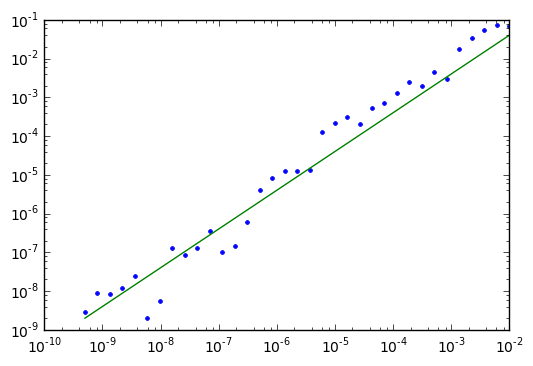

In [8]:
MSD = msd
dct = MSD[1:]/tt[1:]/4./Dt
%matplotlib inline
import matplotlib.pyplot as plt
plt.loglog(tt,MSD,'.')
plt.plot(tt,4.*Dt*np.array(tt))

(0.2, 1.1)

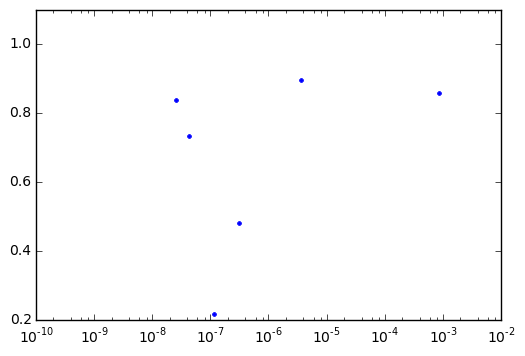

In [9]:
plt.semilogx(tt[1:],dct,'.')
plt.ylim(0.2,1.1)

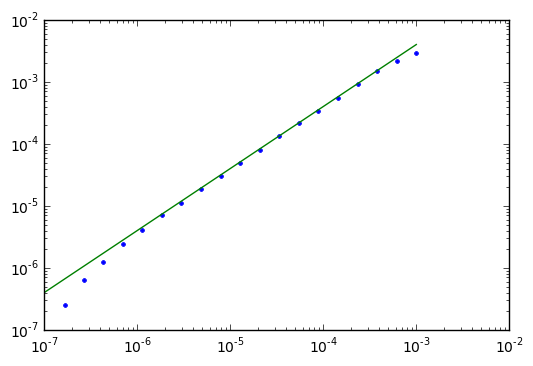

In [6]:
msd = MSD/norun
dct = msd[1:]/tt[1:]/4./Dt
import matplotlib.pyplot as plt
plt.loglog(tt,msd,'.')
#plt.semilogx(tt[1:],dct,'.')
plt.plot(tt,4.*Dt*np.array(tt))


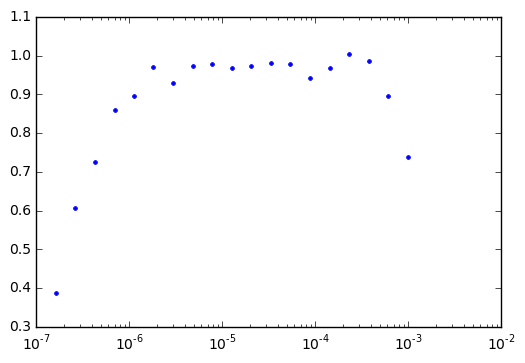

In [7]:
msd = MSD/norun
dct = msd[1:]/tt[1:]/4./Dt
import matplotlib.pyplot as plt
#plt.loglog(tt,msd,'.')
plt.semilogx(tt[1:],dct,'.')
#plt.plot(tt,4.*Dt*np.array(tt))

In [ ]:
data=obs.data()
leng = np.array(data).shape[1]
msd=np.zeros(leng,float) #zeros array for initiation of sum of squared displacement
for i in range(Nt):
     msd += np.array(
     [np.linalg.norm(np.array(tuple(pos)) - np.array(tuple(data[i][0]))) ** 2
          for pos in data[i]]) 

msd = msd/Nt
t=np.arange(0,dur,simdt)
name = 'data/BDphi'+str(phio)+'/phi'+str(phio)+'run'+str(run)+'.csv'
filename = open(name,'w')
np.savetxt(filename,np.column_stack((t,msd)),delimiter=',',fmt='%s')
filename.close()
print 'saving to ',name

In [13]:
#M = max(3, int(min(cbrt(N), L / max(diameter))))
print Nall
print int((Nall)**(1./2))
print int(L/rm)

2303
47
200


In [15]:

Deff = msd[1:]/t[1:]/4/Dt
plt.plot(t,msd)
plt.plot(t,4*Dt*t,'g-')  #theoretical line
plt.xlabel("time")
plt.ylabel("msd")
plt.show()

In [3]:
plt.loglog(t[1:],Deff)
plt.xlabel("time")
plt.ylabel("D/Do")
print np.mean(Deff[-10:])
plt.show()

0.748632071987


In [9]:
#viz.plot_world(w)

In [7]:
print Deff[-10:]

[ 0.31446205  0.31451613  0.3146622   0.3142563   0.31506291  0.31394816
  0.31434592  0.31380255  0.31425508  0.31323333]


In [11]:
p = w.list_particles(Species("M"))

In [13]:
print len(p)+186+74611

186528


In [6]:
print tuple(Integer3(1,1,1)*3)

(3, 3, 3)


In [5]:
from ecell4 import *
import numpy as np
import math
import sys
import os
rng = core.GSLRandomNumberGenerator()
phit = 0.1 
run = 1
print 'run',run
rm = 0.005
Dt = 1
dtfactor = 1e-3
tmol = (2*rm)**2 / (2*Dt)
Ap = math.pi*rm*rm
Nt = 5
At = Nt*Ap/phit
L = At**0.5
mat = Integer3(1,1,1)*int(L/2/rm)#max(3,int((Nall)**(1./2)))
print 'matrix size',tuple(mat)
print 'phit',Nt*Ap/At,'Nt',Nt
tt = np.logspace(-8,-4,40)
tt = np.insert(tt,0,0.)
dur = tt[-1]#tmol*10**5
rng.seed(run)
w = egfrd.EGFRDWorld(Real3(L,L,L),matrix_sizes=mat,rng=rng)
x,y,z = w.actual_lengths()

with species_attributes():
     T | {'D':str(Dt),'radius':str(rm)}
m=get_model()
w.bind_to(m)
for i in range(Nt):
     while(True):
        (pid,p),suc = w.new_particle(Species("T"),Real3(0,rng.uniform(0.0,L),rng.uniform(0.0,L)))
        if (suc): break
PID = [pid for pid, p in w.list_particles(Species("T"))] #particle IDs
sim = egfrd.BDSimulator(w)
sim.set_dt(tmol*dtfactor)
sim.initialize()
if (run==0):
    print 'L={},rm={},Dt={},tmol={:.2E},duration={},simdt={}'.format(L,rm,Dt,tmol,dur,sim.dt())
simdt = sim.dt()
obs = TimingTrajectoryObserver(tt,PID,True,tmol)
sim.run(dur,obs)
data=obs.data()
msd = np.zeros(len(tt),float)
for i in range(Nt):
    msd += np.array(
        [np.linalg.norm(np.array(tuple(pos)) - np.array(tuple(data[i][0]))) ** 2
             for pos in data[i]]) 
msd = msd/Nt
dirname = 'data/BDmocphi'+str(phit)
if not os.path.exists(dirname):
    os.makedirs(dirname)
name = dirname + '/phi'+str(phit)+'run'+str(run)+'.csv'
filename = open(name,'w')
np.savetxt(filename,np.column_stack((tt,msd)),delimiter=',',fmt='%s')
filename.close()
print 'saving to ',name

run 1
matrix size (6, 6, 6)
phit 0.1 Nt 5
saving to  data/BDmocphi0.1/phi0.1run1.csv
